## 로지스틱 회귀

- 선형회귀방식을 분류에 적용한 알고리즘
- 시그모이드 함수를 이용 함수의 반환값을 확률로 간주해 분류를 결정
- 가볍고 빠르지만 이진분류나 텍스트 분류에서 좋은 성능을 냄

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

cancer = load_breast_cancer()

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# StandardScaler()로 평균이 0, 분산이 1로 데이터 분포도 변환
scaler = StandardScaler()
data_scaled = scaler.fit_transform(cancer.data)

X_train, X_test, y_train, y_test = train_test_split(data_scaled, cancer.target, test_size = 0.3, random_state = 0)

In [4]:
from sklearn.metrics import accuracy_score, roc_auc_score

# 로지스틱 회귀를 이용하여 학습 및 예측 수행
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_preds = lr_clf.predict(X_test)

# accuracy와 roc_auc 측정
print('accuracy: {:0.3f}'.format(accuracy_score(y_test,lr_preds)))
print('roc_auc: {:0.3f}'.format(roc_auc_score(y_test,lr_preds)))

accuracy: 0.982
roc_auc: 0.979


In [9]:
from sklearn.model_selection import GridSearchCV

params = {'penalty' : ['l1','l2'],
          'C':[0.01 ,0.1 ,1,5 ,10]}

grid_clf = GridSearchCV(lr_clf, param_grid = params, scoring = 'accuracy', cv = 3)
grid_clf.fit(data_scaled, cancer.target)
print('최적 하이퍼 파라미터 : {0}, 최적 평균 정확도:{1:.3f}'.format(grid_clf.best_params_,
                                                   grid_clf.best_score_))

최적 하이퍼 파라미터 : {'C': 0.1, 'penalty': 'l2'}, 최적 평균 정확도:0.979


## 회귀트리

- 회귀트리를 이용한 트리기반의 회귀
- X값의 균일도를 반영해 지니계수에 따라 분할
- CART(Classification And Regression Trees) 알고리즘에 기반
- 회귀계수를 확인하는 coef_ 속성은 없으나 feature_importances_를 이용해 피처별 중요도를 알 수 있음

In [11]:
from sklearn.datasets import load_boston
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np

# 보스턴 데이터 세트 로드
boston = load_boston()
bostonDF = pd.DataFrame(boston.data, columns = boston.feature_names)
bostonDF['PRICE'] = boston.target

y_target = bostonDF['PRICE']
X_data = bostonDF.drop('PRICE', axis = 1)

rf = RandomForestRegressor(random_state=0, n_estimators=1000)
neg_mse_scores = cross_val_score(rf, X_data, y_target, scoring = "neg_mean_squared_error",cv = 5)
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print(' 5 교차 검증의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 2))
print(' 5 교차 검증의 개별 RMSE scores : ', np.round(rmse_scores, 2))
print(' 5 교차 검증의 평균 RMSE : {0:.3f} '.format(avg_rmse))

 5 교차 검증의 개별 Negative MSE scores:  [ -7.92 -13.03 -20.51 -46.35 -18.95]
 5 교차 검증의 개별 RMSE scores :  [2.81 3.61 4.53 6.81 4.35]
 5 교차 검증의 평균 RMSE : 4.423 


In [12]:
# 다른 알고리즘도 한번에 성능을 측정하기 위한 함수를 만든다
def get_model_cv_prediction(model, X_data, y_target):
    neg_mse_scores = cross_val_score(model, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
    rmse_scores = np.sqrt(-1 * neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)
    print('#### ',model.__class__.__name__,' ####')
    print(' 5 교차 검증의 평균 RMSE : {0:.3f} '.format(avg_rmse))

In [19]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import warnings

warnings.filterwarnings('ignore')

dt_reg = DecisionTreeRegressor(random_state = 0, max_depth = 4)
rf_reg = RandomForestRegressor(random_state = 0, n_estimators = 1000)
gb_reg = GradientBoostingRegressor(random_state=0, n_estimators=1000)
xgb_reg = XGBRegressor(n_estimators=1000, objective='reg:tweedie')
lgb_reg = LGBMRegressor(n_estimators=1000)

# 트리기반의 회귀 모델을 반복하면서 평가 수행
models = [dt_reg,rf_reg,gb_reg,xgb_reg,lgb_reg]

for model in models:
    get_model_cv_prediction(model,X_data, y_target)


####  DecisionTreeRegressor  ####
 5 교차 검증의 평균 RMSE : 5.958 
####  RandomForestRegressor  ####
 5 교차 검증의 평균 RMSE : 4.423 
####  GradientBoostingRegressor  ####
 5 교차 검증의 평균 RMSE : 4.195 
####  XGBRegressor  ####
 5 교차 검증의 평균 RMSE : 4.055 
####  LGBMRegressor  ####
 5 교차 검증의 평균 RMSE : 4.598 


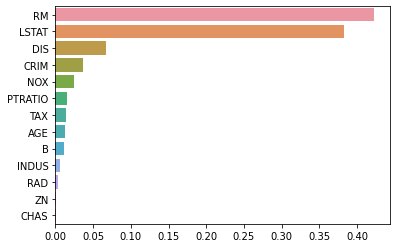

In [21]:
import seaborn as sns
%matplotlib inline

rf_reg = RandomForestRegressor(n_estimators=1000)

# 앞 예제에서 만들어진 X_data, y_target 데이터 셋을 적용하여 학습합니다.
rf_reg.fit(X_data, y_target)

feature_series = pd.Series(data=rf_reg.feature_importances_, index = X_data.columns)
feature_series = feature_series.sort_values(ascending=False)
sns.barplot(x=feature_series, y=feature_series.index)
plt.show()

(100, 2)


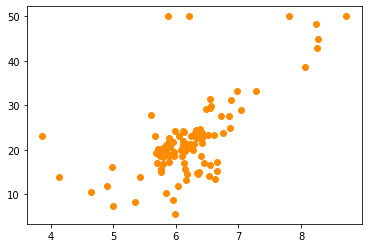

In [23]:
bostonDF_sample = bostonDF[['RM',"PRICE"]]
bostonDF_sample = bostonDF_sample.sample(n = 100, random_state=0)
print(bostonDF_sample.shape)
plt.figure()
plt.scatter(bostonDF_sample.RM,bostonDF_sample.PRICE, c = "darkorange")
plt.show()

선형 및 회귀트리 max_depth에 따라 어떤변화가 있는지 살펴봄

In [24]:
from sklearn.linear_model import LinearRegression

# 선형회귀와 결정트리 기반의 Regressor 생성, DecisionTreeRegressor의 max_depth는 각각 2, 7
lr_reg = LinearRegression()
rf_reg2 = DecisionTreeRegressor(max_depth=2)
rf_reg7 = DecisionTreeRegressor(max_depth=7)

# 실제 예측을 적용할 테스트용 데이터 셋을 4.5 ~ 8.5까지 100개 데이터 셋 생성.
X_test = np.arange(4.5, 8.5, 0.04).reshape(-1,1)

# 보스턴 주택가격 데이터에서 시각화를 위해 피처는 RM만 그리고 결정데이터인 PRICE만 사용
X_feature = bostonDF_sample['RM'].values.reshape(-1,1)
y_target = bostonDF_sample['PRICE'].values.reshape(-1,1)

# 학습과 예측 수행
lr_reg.fit(X_feature, y_target)
rf_reg2.fit(X_feature, y_target)
rf_reg7.fit(X_feature, y_target)

pred_lr = lr_reg.predict(X_test)
pred_rf2 = rf_reg2.predict(X_test)
pred_rf7 = rf_reg7.predict(X_test)

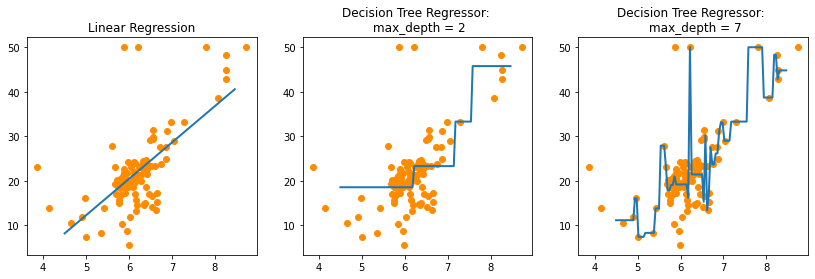

In [27]:
fig,(ax1,ax2,ax3) = plt.subplots(figsize = (14,4),ncols = 3)

# X축값을 4.5 ~ 8.5로 변환하며 입력했을 때 선형회귀와 결정 트리 회귀 예측 선 시각화
# 선형회귀로 학습된 모델 회귀 예측선
ax1.set_title('Linear Regression')
ax1.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c="darkorange")
ax1.plot(X_test, pred_lr, label="linear", linewidth = 2)

# DecisionTreeRegressor의 max_depth를 2로 했을때 회귀 예측선
ax2.set_title('Decision Tree Regressor: \n max_depth = 2')
ax2.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c="darkorange")
ax2.plot(X_test, pred_rf2, label="max_depth:2", linewidth = 2)

# DecisionTreeRegressor의 max_depth를 7로 했을때 회귀 예측선
ax3.set_title('Decision Tree Regressor: \n max_depth = 7')
ax3.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c="darkorange")
ax3.plot(X_test, pred_rf7, label="max_depth:7", linewidth = 2)

plt.show()